## Libraries and includes
---


Una oda al asociado: <br/>
Felipiño el niño, <br>
Con peinado de monaguillo <br/>
con gracia de picadillo <br/>
siempre bien rarillo <br/>
y con la coraza de un armadillo,<br/>
Felipiño el niño <br/>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

#from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16

import os, glob, random, math
import shutil

from shutil import copyfile,copy

## Download and process the data set
---



##### Download from github

In [2]:
#!git clone https://github.com/octavio-navarro/DL_Data_sets.git
!git clone https://github.com/felipeflourwears/DataSet_Traffic_sign.git



Cloning into 'DataSet_Traffic_sign'...
remote: Enumerating objects: 3663, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 3663 (delta 0), reused 184 (delta 0), pack-reused 3478
Receiving objects: 100% (3663/3663), 26.72 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
! pwd 

/content


##### Show an image from the data set

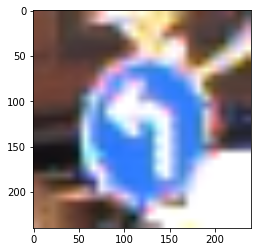

In [74]:
stuff = cv2.imread('/content/DataSet_Traffic_sign/data_set/00034/00000_00002.ppm')
stuff = cv2.cvtColor(stuff,cv2.COLOR_BGR2RGB)
stuff = cv2.resize(stuff,(240,240))
plt.imshow(stuff)

In [75]:
def preproccessImage(image):
  image = image.astype(np.uint8)
  image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

  H, S, V = cv2.split(image_hsv)

  eq_H = cv2.equalizeHist(H)
  eq_S = cv2.equalizeHist(S)
  eq_V = cv2.equalizeHist(V)

  image_eq_hsv = cv2.merge([H, S, eq_V])
  image_eq_hsv = cv2.cvtColor(image_eq_hsv, cv2.COLOR_HSV2RGB)
  return image_eq_hsv.astype(np.float64)/255

In [6]:
stuff.shape

(240, 240, 3)

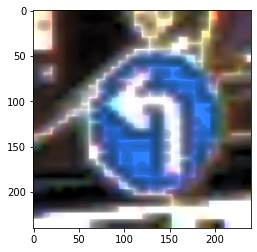

In [64]:
p = preproccessImage(stuff)
plt.imshow(p)

##### Separates the data into different folders

In [7]:
# FILEPATH  + DATASET_FOLDERS[i] + "/*.*"
DRIVE_PATH = "/content/drive/Shareddrives/Semestre6"
FILEPATH = "/content/DataSet_Traffic_sign/"
DATASET_NAME = "DataSet_Traffic_sign"
MODEL_CHECKPOINTS = "MODELO_VGG16"
MODEL_SAVE_DIRECTORY = os.path.join(DRIVE_PATH,MODEL_CHECKPOINTS)
DATASET_FOLDERS = ["00014","00032","00033","00034","00035","00040"]###
IMAGE_PATHS = [os.path.join(FILEPATH,os.path.join("data_set",os.path.join(DATASET_FOLDERS[i],"*.*"))) for i in range(len(DATASET_FOLDERS))]
TRAIN_DIR = os.path.join(DRIVE_PATH, os.path.join(DATASET_NAME, 'training_set'))
TEST_DIR = os.path.join(DRIVE_PATH,os.path.join(DATASET_NAME, 'test_set')) 
IMAGE_LABELS = ["stop_signal","aplastame","right_signal","left_signal","up_signal","around_signal"]  ###
TRAIN_DIRECTORIES = [os.path.join(DRIVE_PATH,os.path.join(TRAIN_DIR,IMAGE_LABELS[i])) for i in range(len(IMAGE_LABELS))]
TEST_DIRECTORIES = [os.path.join(DRIVE_PATH,os.path.join(TEST_DIR,IMAGE_LABELS[i])) for i in range(len(IMAGE_LABELS))]

In [8]:
print(MODEL_SAVE_DIRECTORY)

/content/drive/Shareddrives/Semestre6/MODELO_VGG16


In [9]:
imageLists = [glob.glob(IMAGE_PATHS[i]) for i in range(len(IMAGE_PATHS))]

In [10]:
# orden -> lista entrenamiento | lista test
def splitImageDirectory(imageList,trainPercentage = 0.8):
  trainLen = int(len(imageList)*trainPercentage)
  return (imageList[:trainLen],imageList[trainLen:])

In [11]:
trainTestSplits = [splitImageDirectory(imageList) for imageList in imageLists]

In [12]:
train,test = trainTestSplits[0]
print(len(train),len(test))

624 157


In [13]:
def tranferImages(imageList,filepath):
  for image in imageList:
    try:
      copy(image,filepath)
    except:
      continue

In [14]:
def createLabelFilepaths(filepath,labelsFilepahts):
  os.chdir(filepath)
  for labelPath in labelsFilepahts:
    if not os.path.exists(labelPath):
      print(labelPath)
      os.mkdir(labelPath)
    else:
      shutil.rmtree(labelPath,ignore_errors=True)
      os.mkdir(labelPath)

In [15]:
def createTrainTestDirectories(filepath,labelsFilepahts):
  if os.path.exists(filepath):
    shutil.rmtree(filepath,ignore_errors=True)
    os.mkdir(filepath)
    createLabelFilepaths(filepath,labelsFilepahts)
  else:
    print(filepath)
    os.chdir(os.path.join(DRIVE_PATH,FILEPATH))
    os.mkdir(filepath)
    createLabelFilepaths(filepath,labelsFilepahts)

In [16]:
def createFullDataset():
  createTrainTestDirectories(TEST_DIR,TEST_DIRECTORIES)
  createTrainTestDirectories(TRAIN_DIR,TRAIN_DIRECTORIES)
  os.chdir("/content")
  for i in range(len(trainTestSplits)):
    tupp = trainTestSplits[i]
    tranferImages(tupp[0],TRAIN_DIRECTORIES[i])
    tranferImages(tupp[1],TEST_DIRECTORIES[i])
    


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
createFullDataset()

/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set/stop_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set/aplastame
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set/right_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set/left_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set/up_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set/around_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set/stop_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set/aplastame
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set/right_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set/left_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set/up_signal
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set/around_signal


## Model definition and training
---

##### Define and compile a model to classify the images. You can look at other models for inspiration.

In [19]:
IMG_INPUT_SHAPE = (224,224,3)
TARGET_DIMS = (224,224)
BATCH_SIZE = 64


In [20]:
convolutional =  VGG16(weights='imagenet', include_top = False, input_shape=IMG_INPUT_SHAPE)
convolutional.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [21]:
dersiredTrainedBlocks = ["input","block1","block2","block3","block4"]
for layer in convolutional.layers:
  if layer.name.split("_")[0] in dersiredTrainedBlocks:
    layer.trainable = False

In [22]:
# TODO: Define a model to classify the images. Don't forget to show its summary and compile it.
l = Flatten(name = "flatten")(convolutional.layers[-1].output)
l = Dense(128,activation = "relu",name = "block6_dense1")(l)
l = Dropout(0.2,name = "block6_dropout1")(l)
l = Dense(32,activation = "relu",name = "block6_dense2")(l)
output = Dense(6,activation="softmax",name = "output")(l)

model = Model(inputs = convolutional.layers[0].input,outputs = output)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
flatten True
block6_dense1 True
block6_dropout1 True
block6_dense2 True
output True


#### Add data agumentation to the data set.

##### Define the image data generator. Define transformations that make sense for the data set.

In [25]:
print(TRAIN_DIR)
print(TEST_DIR)

/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/training_set
/content/drive/Shareddrives/Semestre6/DataSet_Traffic_sign/test_set


In [26]:
# TODO: Define an image data generator for training and for testing.
augmentedDataGen = ImageDataGenerator(
#rescale=1./255,
rotation_range = 40,
width_shift_range = 0.2,
height_shift_range = 0.2,
shear_range = 0.2,
zoom_range=0.2,
horizontal_flip=False,
vertical_flip = False,
validation_split=0.2,
fill_mode='nearest',
preprocessing_function = preproccessImage 

)


testDataGen = ImageDataGenerator(
#rescale=1./255
preprocessing_function = preproccessImage 

)

##### Define the train, validation, and test generators

In [27]:
# TODO: Create generators for training, validation, and testing.
trainGenetator = augmentedDataGen.flow_from_directory(
TRAIN_DIR,
target_size=TARGET_DIMS,
batch_size=BATCH_SIZE,
class_mode='categorical',
subset='training')

validationGenerator = augmentedDataGen.flow_from_directory(
TRAIN_DIR,
target_size=TARGET_DIMS,
batch_size=BATCH_SIZE,
class_mode='categorical',
subset='validation')


# Image data generator for the test data: it is processed the same as the train data
testGenerator = testDataGen.flow_from_directory(
TEST_DIR,
target_size=TARGET_DIMS,
batch_size=BATCH_SIZE,
class_mode='categorical')

Found 2321 images belonging to 6 classes.
Found 577 images belonging to 6 classes.
Found 731 images belonging to 6 classes.


##### Using matplotlib, visualize images from the test generator. Create a figure of 20 images, with 5 images per row.

In [28]:
# TODO: Create a figure with images from the test generator.



##### Train the model using the generators. Investigate what 'Early stopping' is, and implement it for the training. Don't forget to use a GPU for training.

In [29]:
# TODO: Train the model. Remember to use Early stopping.
def checkModelCheckpointsDir():
  if not os.path.exists(MODEL_SAVE_DIRECTORY):
    os.chdir(DRIVE_PATH)
    os.mkdir(MODEL_SAVE_DIRECTORY)
    os.chdir("/content/")

In [30]:
checkModelCheckpointsDir()

In [31]:
model.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [32]:
check = ModelCheckpoint(filepath=MODEL_SAVE_DIRECTORY,save_weights_only=False,frequency="epoch",monitor = "val_accuracy",save_best_only=True,verbose = 1)
stop = EarlyStopping(mode="max",patience = 5,min_delta = 0.05,monitor ="val_accuracy")

In [33]:
print(MODEL_SAVE_DIRECTORY)
os.path.exists(MODEL_SAVE_DIRECTORY)

/content/drive/Shareddrives/Semestre6/MODELO_VGG16


True

In [34]:
hist = model.fit(
  trainGenetator,
  epochs=100,
  validation_data=validationGenerator,
  steps_per_epoch=trainGenetator.samples // BATCH_SIZE,
  validation_steps=validationGenerator.samples // BATCH_SIZE,
  callbacks=[check,stop],
  verbose = 1
  )

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 2.8386 - accuracy: 0.2831
Epoch 1: val_accuracy improved from -inf to 0.33160, saving model to /content/drive/Shareddrives/Semestre6/MODELO_VGG16
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Semestre6/MODELO_VGG16/assets
36/36 [==============================] - 69s 1s/step - loss: 2.8386 - accuracy: 0.2831 - val_loss: 1.6704 - val_accuracy: 0.3316
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 1.6558 - accuracy: 0.3097
Epoch 2: val_accuracy did not improve from 0.33160
36/36 [==============================] - 48s 1s/step - loss: 1.6558 - accuracy: 0.3097 - val_loss: 1.7158 - val_accuracy: 0.2448
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 2.1760 - accuracy: 0.2880
Epoch 3: val_accuracy did not improve from 0.33160
36/36 [==============================] - 47s 1s/step - loss: 2.1760 - accuracy: 0.2880 - val_loss: 2.6878 - val_accuracy: 0.3264
Epoch 4/100
3

## Model evaluation
---

##### Evaluate the performance of the model with the test generator.

Text(0, 0.5, 'acc')

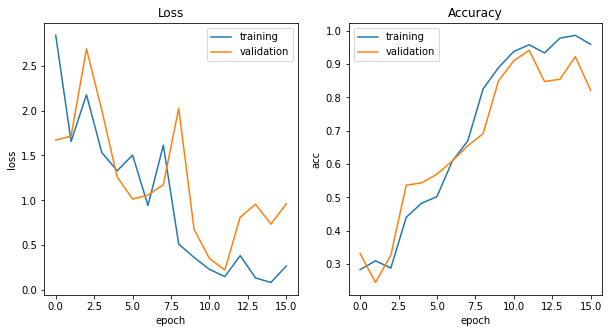

In [35]:
# TODO: Evaluate the model, and print the results.


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["training","validation"])
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.legend(["training","validation"])
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")



##### Plot the results of training: plot training and validation accuracy, and loss.

In [36]:
# TODO: Plot the results of the training and validation accuracy.

# TODO: Plot the results of the training and validation loss.

model.evaluate(testGenerator)

12/12 [==============================] - 6s 537ms/step - loss: 0.4490 - accuracy: 0.9111


[0.4489883482456207, 0.9110807180404663]

In [52]:
model.save(os.path.join(MODEL_SAVE_DIRECTORY,"puzzlebot_model.h5"))


In [53]:
model.save(os.path.join(MODEL_SAVE_DIRECTORY,"puzzlebot_model.pb"))

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Semestre6/MODELO_VGG16/puzzlebot_model.pb/assets


In [39]:
SAMPLE_IMAGES = os.path.join(DRIVE_PATH,"SampleImages")

In [65]:
os.chdir(SAMPLE_IMAGES)
NAMES = os.listdir()
IMAGES = [cv2.imread(name) for name in NAMES]
IMAGES = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in IMAGES]
os.chdir("/content/")
RESIZE = [cv2.resize(img,(224,224)) for img in IMAGES]
NORM = [img.reshape(1,224,224,3) for img in RESIZE]
NORM = [img/255.0 for img in NORM]

In [66]:
labels = (trainGenetator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels[0]

'aplastame'

In [67]:
labels

{0: 'aplastame',
 1: 'around_signal',
 2: 'left_signal',
 3: 'right_signal',
 4: 'stop_signal',
 5: 'up_signal'}

In [68]:
INDEX = 2

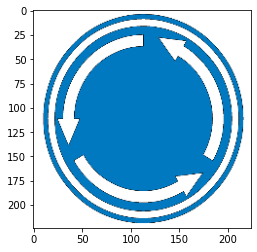

In [69]:
plt.imshow(RESIZE[INDEX])

In [70]:
labels[np.argmax(model.predict(NORM[INDEX]))]

'right_signal'